20:16:01 - cmdstanpy - INFO - Chain [1] start processing
20:16:01 - cmdstanpy - INFO - Chain [1] done processing


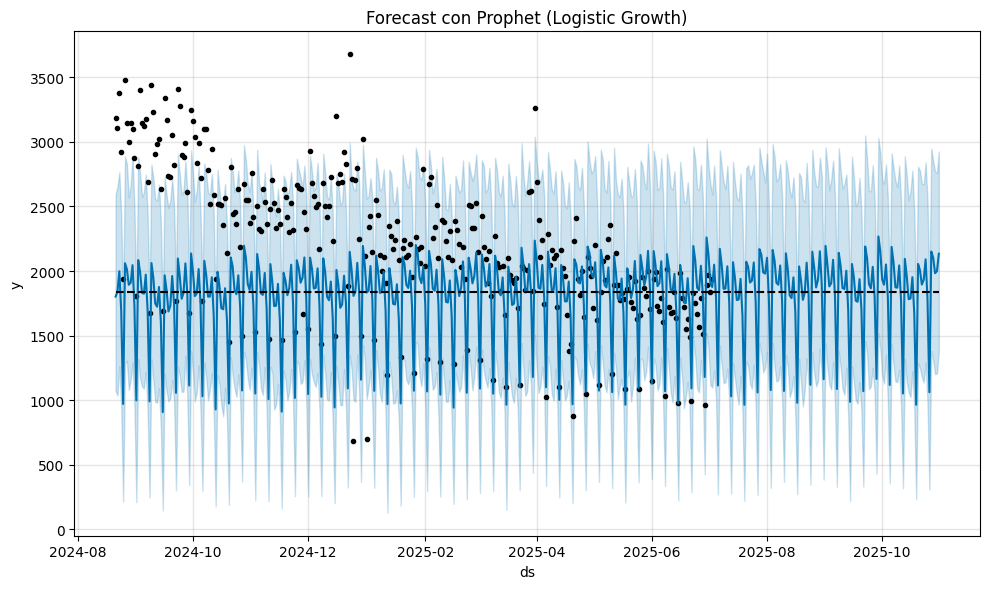

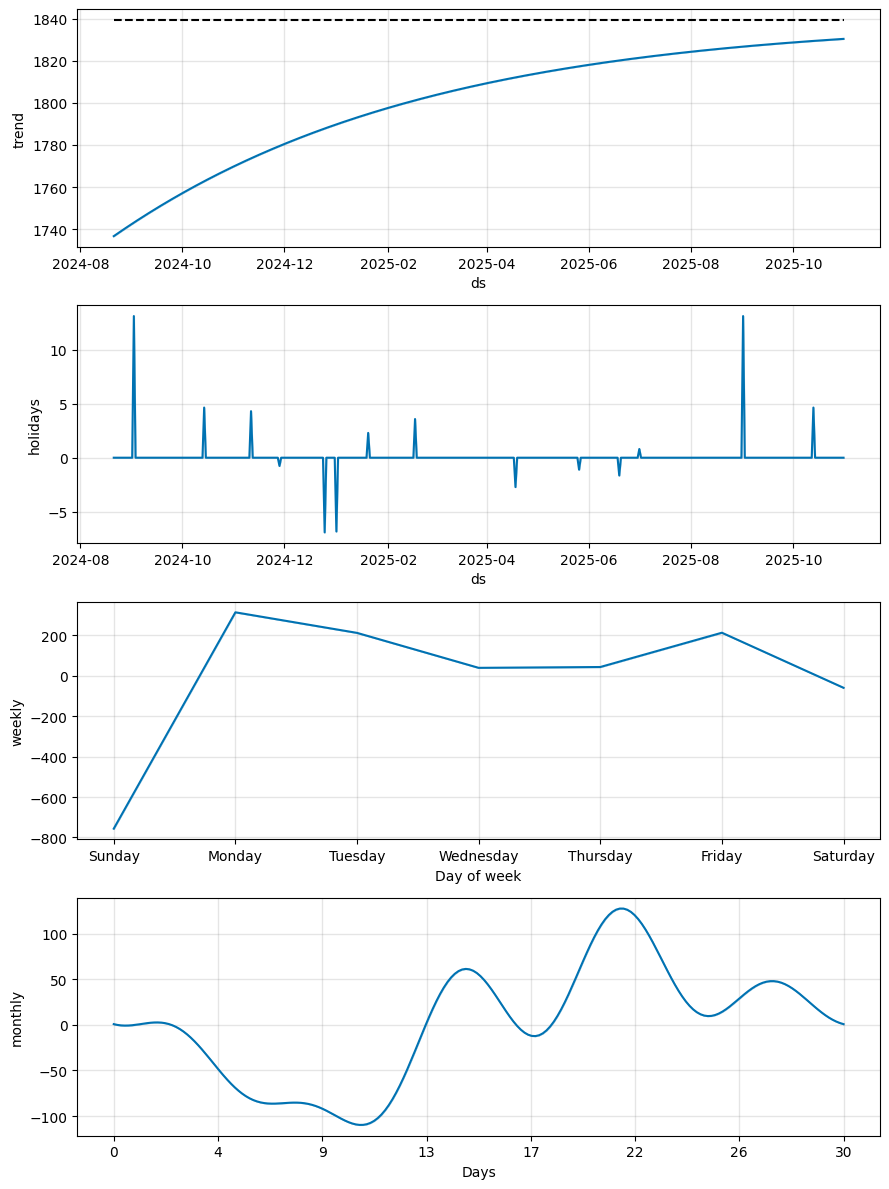

In [28]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from datetime import timedelta
from prophet.make_holidays import get_country_holidays_class

# Set Plotly to open in browser
pio.renderers.default = "browser"

# 1. Cargar el archivo Excel
df = pd.read_excel("data.xlsx", engine="openpyxl")

# 2. Limpiar datos
df = df.dropna(subset=["date", "calls", "skill"])
df = df[df["calls"] != 0]
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# 3. Preparar datos para Prophet
df_prophet = df[["date", "calls"]].rename(columns={"date": "ds", "calls": "y"})

# 3.1 Agregar columna 'cap' para crecimiento logístico

cap_value = df_prophet["y"].max() * .5  #Calcula un valor de capacidad (cap) como el 120% del valor máximo observado en los datos. 
                                            #Esto define el límite superior del crecimiento logístico. 
                                            #Si se elige un valor demasiado bajo, el modelo se saturará muy pronto; si es demasiado alto, el efecto logístico será casi lineal.

df_prophet["cap"] = cap_value               #Asigna ese valor de capacidad a toda la columna 'cap', que Prophet requiere para modelar el crecimiento logístico. 
                                            #Cada fila debe tener un valor de 'cap' correspondiente.


# 4. Crear festivos combinados para US y CA
start_year = df_prophet["ds"].min().year
end_year = (df_prophet["ds"].max() + timedelta(days=120)).year
years = list(range(start_year, end_year + 1))

def make_combined_holidays_df(countries, years):
    all_holidays = []
    for country in countries:
        country_class = get_country_holidays_class(country)
        holidays = country_class(years=years)
        df_holidays = pd.DataFrame({
            'ds': pd.to_datetime(list(holidays.keys())),
            'holiday': [', '.join(holidays.get_list(date)) for date in holidays]
        })
        all_holidays.append(df_holidays)
    return pd.concat(all_holidays, ignore_index=True)

holidays_df = make_combined_holidays_df(["US", "CA"], years)

# 5. Crear y entrenar el modelo Prophet con crecimiento logístico
model = Prophet(
    growth='logistic',                # Define el tipo de crecimiento. 'logistic' modela una curva en forma de S que se estabiliza al acercarse a un límite (capacidad). Cambiar a 'linear' permite crecimiento indefinido.
    changepoint_prior_scale=0.01,   # Controla la flexibilidad de la tendencia. Valores bajos (como este) hacen la tendencia más rígida y suave; valores altos permiten más cambios bruscos.
    seasonality_prior_scale=20,       # Controla cuánto puede influir la estacionalidad. Valores altos permiten que la estacionalidad tenga más peso; valores bajos la suavizan.
    weekly_seasonality=True,          # Activa la estacionalidad semanal. Útil si hay patrones que se repiten cada semana (como menos llamadas los fines de semana).
    daily_seasonality=False,          # Desactiva la estacionalidad diaria. Activarla solo si hay patrones claros por hora o día (no común en datos agregados diarios).
    seasonality_mode='additive',      # Define cómo se combina la estacionalidad con la tendencia. 'additive' suma la estacionalidad; 'multiplicative' la escala proporcionalmente (útil si la variación crece con el nivel).
    holidays=holidays_df              # Incluye efectos de días festivos personalizados. Puede mejorar la precisión si hay caídas o picos en días festivos específicos.
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)

# 6. Crear fechas para pronóstico
last_date = df_prophet["ds"].max()
future = model.make_future_dataframe(periods=120, freq='D')
future["cap"] = cap_value

# 7. Generar pronóstico
forecast = model.predict(future)

# 8. Preparar tabla de resultados
result = forecast[["ds", "yhat"]].rename(columns={"ds": "date", "yhat": "forecast"})
calls_map = df_prophet.set_index("ds")["y"].to_dict()
result["calls"] = result["date"].map(calls_map).fillna(0)

# 9. Exportar a Excel
result.to_excel("forecast.xlsx", index=False)

# 10. Gráficas estándar de Prophet
model.plot(forecast)
plt.title("Forecast con Prophet (Logistic Growth)")
plt.tight_layout()
plt.show()

model.plot_components(forecast)
plt.tight_layout()
plt.show()

# 11. Gráfica comparativa con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=result["date"], y=result["forecast"], mode='lines', name='Pronóstico'))
fig.add_trace(go.Scatter(x=result["date"], y=result["calls"], mode='lines', name='Llamadas reales'))
fig.update_layout(title="Comparación de Pronóstico vs Llamadas Reales", xaxis_title="Fecha", yaxis_title="Llamadas")
fig.show()

